<div dir=rtl>

#  פרויקט קורס סקרנות
  מגישים: שי פרח ת.ז 025257957 , 
אלון מזרחי ת.ז 312284706

<div dir=rtl>

# עבור פרויקט זה נשתמש במסד הנתונים של האירוסים לסיווג מולטי-קלאס 

<div dir=rtl>

## טעינת הספריות

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from google.colab import data_table # Enables rendering of pandas dataframes into interactive displays
data_table.enable_dataframe_formatter()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats



<div dir=rtl>

# חלק א': 
## 1. ניסוח הבעיה: בחירת בעיית למידה

<div dir=rtl>

## טעינת הנתונים 

In [ ]:
# load the dataset
path = "https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv"
df = read_csv(path)




<img src=https://camo.githubusercontent.com/74e378bb24b34efb63e8db09c4f073370d36f23aaa2c7580a805e93c881b78c2/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f6173736574732e6461746163616d702e636f6d2f626c6f675f6173736574732f4d616368696e652b4c6561726e696e672b522f697269732d6d616368696e656c6561726e696e672e706e67>

The Iris Dataset consists of 50 samples each of three different species of iris flower: setosa, versicolor and virginica. It contains four different measurements for each sample in centimetres - the length and width of sepals and petals - making it a multivariate dataset.
<img src=https://miro.medium.com/max/1400/1*2vTEJYgA9TnWPM81fBz7tw.webp>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


<div dir=rtl>

## 2. ניסוח הבעיה בעזרת היקש בייסיאני

מטרת הלמידה היא אימון מודל מודל מסווג לדאטהסט האירוסים.
בדאטהסט זה כל דוגמא מכילה וקטור x בין 4 תכונות מספריות רציפות, ותיוג y, שהוא סוג האירוס הספציפי מתוך שלושה סוגי אירוסים הקיימים בדאטהסט.
 
מטרת האלגוריתם היא לאמן מסווג בתהליך של הסקה בייסיאנית. 
המסווג המאומן יקבל כקלט וקטור  x המכיל את ארבעת התכונות המספריות של האירוס הספציפי ויחזיר כפלט וקטור בין שלושה ערכים המייצגים את ההסתברות 
 
￼P(y_i |x)
  for i= 1,2,3
 
את החישוב ההסתברויות הנ״ל נעשה באמצעות נוסחת בייס

p(y|x) = (p(y)*p(x|y))/p(x)

לשם כך נצטרך להניח :

1.   התכונות בלתי תלויות
2.   התכונות מתפלגות נורמלי

 הנחות אלו לאו דווקא נכונות, לכן מודל הסיווג הזה נקרא גם naive bays


## 'y' is the Iris name (labels), 'x' is the properties of the Iris (features)

### p(y) = class prior 

### p(x|y) = likelihood

### p(y|x) = postirior

### p(x) = feature prior

### p(y|x) = (p(y)*p(x|y))/p(x)

<div dir=rtl>

## 3. תכנות הבעיה והפתרון

In [ ]:
#### utility functions #####
def normalize(p):
  c = p[0] + p[1] + p[2]
  p[0] = p[0]/c
  p[1] = p[1]/c
  p[2] = p[2]/c
  return p

#Function to Calculate Probability using Gaussian Distribution Formula
def get_probability(x, mean, std):
  return stats.norm(loc=mean,scale=std**2).pdf(x)

#A Function to compute Information Gain (IG) using Kullback–Leibler divergence
def IG(proba_before,proba_after):
  Ig_ = 0
  for t in range(len(proba_before)):
    if proba_before[t] > 0.0000 and proba_after[t] > 0.0000: 
      Ig_ += proba_after[t] * np.log2(proba_after[t] / proba_before[t])
  return Ig_


In [ ]:
def update_statistics(classes, class_mean, class_stdev, class_prior,x_t, y_t):
  #extract the first i samples
  current_X_train = x_t
  current_y_train = y_t

  #update class statistics
  for class_idx,class_name in enumerate(classes): #Iterate over all classes
    X_of_class = current_X_train[current_y_train == class_name] #extract the samples of the currnt class
    class_mean[class_idx] = X_of_class.mean(axis=0)
    class_stdev[class_idx] = X_of_class.std(axis=0)
    class_prior[class_idx] = X_of_class.shape[0] / current_X_train.shape[0]
    
  #update feature statistics
  feat_mean = current_X_train.mean(axis=0)
  feat_stdev = current_X_train.std(axis=0)

  return feat_mean, feat_stdev

In [ ]:
def get_postirior(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev, xx):
  post_prob = []
  for class_idx,class_name in enumerate(classes):
    #Calculate P(x|class) 
    likelyhood = get_probability(xx, class_mean[class_idx], class_stdev[class_idx])
    #Calculate P(x)
    feature_prior = get_probability(xx, feature_mean, feature_stdev)
    #Using Bayes Theorem, calculate P(class|x)  
    postirior = class_prior[class_idx]*np.prod(likelyhood)/np.prod(feature_prior)

    #Add class post to the List
    post_prob.append(postirior)
  return post_prob

In [ ]:
def validate_on_test_data(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev, x_test, y_test):
  #Initialized variable for storing Predictions
  prediction = []
  #Iterate over Test Data
  for x in x_test: 
    #Store Best Case Probability
    post_proba = []

    #To Iterate over Each Class
    for class_idx,class_name in enumerate(classes):
      #Calculate P(x|class) 
      likelyhood = get_probability(x, class_mean[class_idx], class_stdev[class_idx])
      #Calculate P(x)
      feature_prior = get_probability(x, feature_mean, feature_stdev)
      #Using Bayes Theorem, calculate P(class|x)  
      postirior = class_prior[class_idx]*np.prod(likelyhood)/np.prod(feature_prior)

      #Add class post to the List
      post_proba.append(postirior)

    #To append Name of Class whose Probability is Max among all the Classes
    prediction.append(classes[np.argmax(post_proba)])
  #Return Accuracy Score
  return accuracy_score(prediction, y_test)

In [ ]:
### start ###

#Extract the dataset's features to the variable'X' and the labels to the variable 'y' 
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
#Split data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

#Get Total No. of Samples and Total No. of Features of Training Dataset
num_of_samples, num_of_featuers = X_train.shape
print(f"X train has {num_of_samples} samples with {num_of_featuers} features each")
print(f"X test has {X_test.shape[0]} such sampels")

X train has 105 samples with 4 features each
X test has 45 such sampels


In [ ]:
#Classes
classes = np.unique(y_train)
num_of_classes = len(classes)
print(classes)

['setosa' 'versicolor' 'virginica']


In [ ]:
#Global variables keeps the statistics of current X_test 
class_mean = np.zeros((num_of_classes, num_of_featuers), dtype=np.float32)
class_stdev = np.zeros((num_of_classes, num_of_featuers), dtype=np.float32)
class_prior = np.zeros(num_of_classes, dtype=np.float32)

feature_mean = np.zeros(num_of_featuers, dtype=np.float32)
feature_stdev = np.zeros(num_of_featuers, dtype=np.float32)


In [ ]:
# initial statistics parameters  

init = 20 # Initialize the model with 'init' first exampls
feature_mean, feature_stdev = update_statistics(classes, class_mean, class_stdev, class_prior, X_train[0:init,:], y_train[0:init])

<div dir=rtl>

### אימון המודל

בחלק זה בוצע אימון (עדכון הפרמטרים הסטטיסטיים על ידי נוסחת בייס), כאשר בחלק הראשון בוצע אימון על פי הסדר של הדאטה ללא תלות ב -Information Gain (בכל שלב חושב ה-IG אך לא בוצע בו שימוש), לאחר מכן בוצע אימון 'סקרני' בו בכל שלב נבדק איזו פיסת מידע תגרום ל- Information Gain מקסימלי, וכך נבחרה פיסת המידע. ניתן לראות בגרפים למטה עבור דיוק כתלות במספר דוגמאות האימון כי עבור אימון 'סקרני' המודל הגיע לדיוק של מעל 90% לפני 20 פיסות מידע, בעוד שבאימון רגיל המודל הגיע לדיוק של 90% רק לאחר 80 פיסות מידע. בנוסף ניתן לראות בגרפים למטה עבור IG כי ה-IG המצטבר גדול יותר באימון סקרני ועולה מהר יותר.

In [ ]:
# Non-curiosity train 
# Iterate over the rest of the samples to fit the model one sample at a time
accuracy_scores = []
IG_scores = []
IG_scores_accu = [] #accumulative
IG2 = 0
for i in range(init+1,num_of_samples):
  #Get P(y|x) before learning from the current (x,y) example
  proba_before = get_postirior(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev,X_train[i,:])

  #Learn the current (x,y) example
  feature_mean, feature_stdev = update_statistics(classes, class_mean, class_stdev, class_prior, X_train[0:i,:], y_train[0:i])

  #Get P(y|x) after learning from the current (x,y) example
  proba_after = get_postirior(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev,X_train[i,:])

  #Compute information gained from learning the current (x,y) example
  IG1 = IG(proba_before,proba_after)
  IG2 +=IG1
  IG_scores.append(IG1)
  IG_scores_accu.append(IG2)
  accuracy = validate_on_test_data(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev, X_test, y_test)
  accuracy_scores.append(accuracy)


In [ ]:
# Bonus
# Curiosity train 

Curiosity_accuracy_scores = []
curiosity_IG_scores = []
curiosity_IG_scores_accu = []
IG_cur2 = 0
ig_max = 0
curiosity_X_train = X_train[:init+1,:]
curiosity_y_train = y_train[:init+1]
new_x_train = X_train[init+1:,:]
new_y_train = y_train[init+1:]
# Iterate over the rest of the samples to fit the model one sample at a time
for i in range(init+1,num_of_samples):
  ig_max = 0
  index_of_ig_max = 0

  # Iterate over the all the train data and save the index of the data with the highest Information Gain
  for j in range(len(new_x_train)):
    #init temporary std and mean
    temp_feature_mean = np.zeros(num_of_featuers, dtype=np.float32)
    temp_feature_stdev = np.zeros(num_of_featuers, dtype=np.float32)

    temp_post_proba_before = get_postirior(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev,curiosity_X_train[-1:,:])
    temp_x_train = np.vstack((curiosity_X_train, new_x_train[j,:]))
    temp_y_train = np.hstack((curiosity_y_train, new_y_train[j]))
    # update temporary statistics parameters
    temp_feature_mean, temp_feature_stdev = update_statistics(classes, class_mean, class_stdev, class_prior, temp_x_train,temp_y_train)
    temp_post_proba_after = get_postirior(classes, class_mean, class_stdev, class_prior, temp_feature_mean, temp_feature_stdev,curiosity_X_train[-1:,:])
    # Calculate IG
    temp_IG = IG(temp_post_proba_before,temp_post_proba_after)
    if(temp_IG > ig_max):
      index_of_ig_max = j
      ig_max = temp_IG
    
  
  post_proba_before = get_postirior(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev,curiosity_X_train[-1:,:])
  # add the best data row to the curiosity train set
  curiosity_X_train = np.vstack((curiosity_X_train, new_x_train[index_of_ig_max,:]))
  curiosity_y_train = np.hstack((curiosity_y_train, new_y_train[index_of_ig_max]))
  
  # remove the row we used with the highest IG
  new_x_train = np.delete(new_x_train, index_of_ig_max, axis=0)
  new_y_train = np.delete(new_y_train, index_of_ig_max, axis=0)

  # update statistics parameters
  feature_mean, feature_stdev = update_statistics(classes, class_mean, class_stdev, class_prior, curiosity_X_train,curiosity_y_train)
  post_proba_after = get_postirior(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev,curiosity_X_train[-1:,:])
  # Calculate IG
  IG_cur = IG(post_proba_before,post_proba_after)
  IG_cur2 += IG_cur
  curiosity_IG_scores.append(IG_cur)
  curiosity_IG_scores_accu.append(IG_cur2)
  accuracy = validate_on_test_data(classes, class_mean, class_stdev, class_prior, feature_mean, feature_stdev, X_test, y_test)
  Curiosity_accuracy_scores.append(accuracy)

# plt.plot(Curiosity_accuracy_scores)
# plt.show()

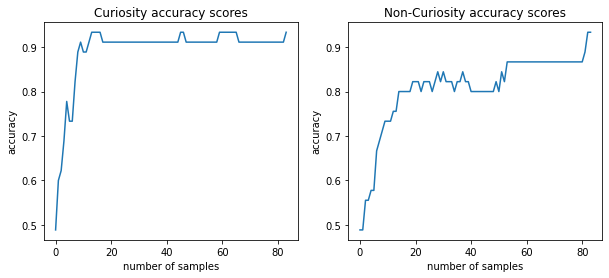

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(Curiosity_accuracy_scores)
ax2.plot(accuracy_scores)
ax1.title.set_text('Curiosity accuracy scores')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('number of samples')
ax2.title.set_text('Non-Curiosity accuracy scores')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('number of samples')
plt.show()

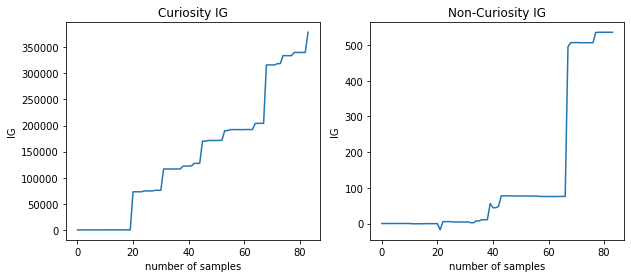

In [ ]:
# accumulated Information gain
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(curiosity_IG_scores_accu)
ax2.plot(IG_scores_accu)
ax1.title.set_text('Curiosity IG')
ax1.set_ylabel('IG')
ax1.set_xlabel('number of samples')
ax2.title.set_text('Non-Curiosity IG')
ax2.set_ylabel('IG')
ax2.set_xlabel('number of samples')
plt.show()